In [55]:
cd ..

/Users/lfinkbeiner/Documents/GitHub/AY121/lab2


In [56]:
%run synthesis

In [57]:
cd analyses

/Users/lfinkbeiner/Documents/GitHub/AY121/lab2/analyses


In [58]:
results = load_saves('../data/calibrator.npz')
results

{'cal_on_median': array([6.04529657e+13, 3.46461871e+10, 2.53879609e+10, ...,
        2.47789582e+10, 2.58308291e+10, 3.53930846e+10]),
 'cal_off_median': array([5.96926399e+13, 3.38740619e+10, 2.48433680e+10, ...,
        2.41342222e+10, 2.52149751e+10, 3.44630277e+10]),
 'cal_on_mean': array([6.06161856e+13, 4.94497090e+10, 3.72847430e+10, ...,
        3.61482422e+10, 3.66009026e+10, 4.94172222e+10]),
 'cal_off_mean': array([5.97887781e+13, 4.80161996e+10, 3.62799246e+10, ...,
        3.51687860e+10, 3.59561361e+10, 4.86470779e+10]),
 'cass_on_mean': array([5.64272541e+13, 1.29264575e+11, 1.14786276e+11, ...,
        1.15380775e+11, 1.14040955e+11, 1.26834330e+11]),
 'cass_off_mean': array([5.71485205e+13, 1.30973650e+11, 1.18510128e+11, ...,
        1.18080850e+11, 1.16121664e+11, 1.30383611e+11]),
 'hot': array([5.67259742e+13, 2.63871130e+12, 2.11994437e+12, ...,
        2.14079207e+12, 2.74826113e+12, 2.71109659e+12]),
 'cold': array([5.61524302e+13, 1.44665068e+11, 1.02551876e+1

In [59]:
cal_on = results['cal_on_mean']
cal_off = results['cal_off_mean']
cass_on = results['cass_on_mean']
cass_off = results['cass_off_mean']
hot = results['hot']
cold = results['cold']

In [60]:
G = gain(hot, cold)

In [61]:
x = freq_range(62.5e6 / 6, 16000) / 10 ** 6

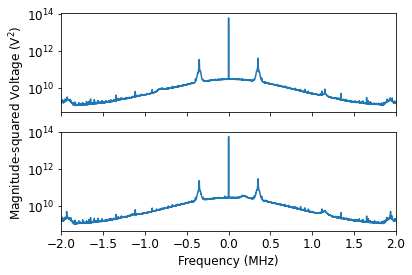

In [62]:
double_pp(x, cal_off, cal_on, (-2, 2), logv=True)

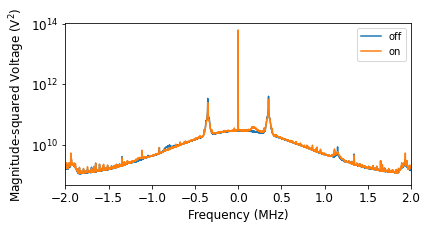

In [63]:
over_pp(x, cal_off, cal_on, 'off', 'on', (-2, 2), logv=True)

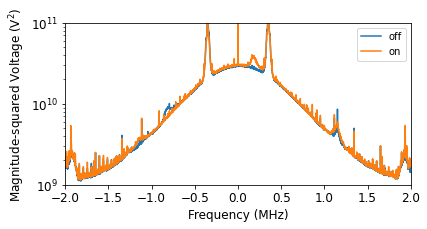

In [64]:
# Here is an example where the y limits are set correctly for a logarithmic plot!
over_pp(x, cal_off, cal_on, 'off', 'on', (-2, 2), (10**9, 10**11),logv=True)

Now we hope to move on to velocity and reference frame.

We observe the line frequency to be about .18 MHz

In [68]:
# Left bound
print(doppler(-2, .18, -0.027923))
# Right bound
print(doppler(2, .18, -0.027923))

3633.3054103333334
-3033.3612563333336


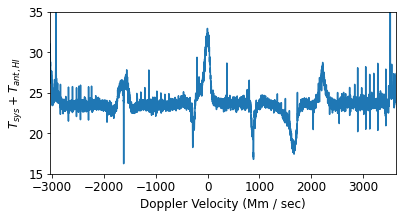

In [72]:
velocities = doppler(x, .18, -0.027923)

pp_skeleton(velocities, G * cal_on / cal_off,
            xBounds = (-3033.3612563333336, 3633.3054103333334),
            yBounds = (15, 35),
            xLabel='Doppler Velocity (Mm / sec)',
            yLabel=r'$T_{sys} + T_{ant, HI}$')

Declination is equal to latitude, which is equal to 37.873199 degrees.
Right ascension was equal to LST, which at that time was 

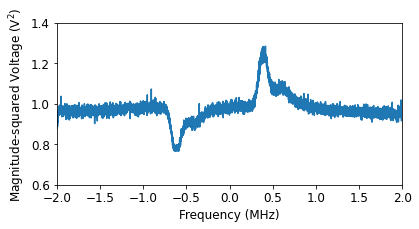

In [67]:
pp_skeleton(x, cass_on / cass_off, (-2, 2), (.6, 1.4))